<a href="https://colab.research.google.com/github/julianaquin/energy-consumption-ML/blob/main/Pet_Adoptability_ML2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PetFinder Adoptability


# Introduction

PetFinder.my has been Malaysia's leading animal protection platform since 2008, with a large database. PetFinder works closely with animal lovers, media, businesses and global organizations to improve animal welfare.

Pet adoption rates are closely linked to the metadata associated with their online profiles, such as descriptive text and photographic features.

In this project (same dataset for machine learning and deep leaning), you'll be developing algorithms that predict pet adoptability - in particular, how quickly an animal will be adopted.

At the end of the project, you must submit:

an executer notebook writed like a report in order to explain your choice and your strategy
your prediction for the test part (2 columns csv with id and prediction rate)
the evaluation metric is the quadratic kappa score (available in sklearn)

# Methodology ML

We first import all of the libraries we wil be using in this notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re

In [ ]:
import zipfile
import os
from IPython.display import display, Image

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import make_scorer, cohen_kappa_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_address= '/content/drive/My Drive/Colab Notebooks/ML2'

In [ ]:
df_train = pd.read_csv(drive_address + '/train.csv')
df_test = pd.read_csv(drive_address + '/test.csv')

In [ ]:
df_test.head()

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,Images,Breed
0,Cat,1.0,Male,Black,White,Unknown,Small,Yes,No,No,No,Healthy,0.0,"kitten for adoption, pls call for enquiry, off...",5df99d229-2.jpg,Domestic_Short_Hair
1,Dog,8.0,Male,Black,Brown,Unknown,Medium,Yes,No,No,No,Healthy,0.0,"Stray puppy that came to my house. Obedient, w...",a08030c6f-2.jpg,Mixed_Breed
2,Dog,2.0,Female,Brown,Cream,White,Medium,Unknown,Yes,Yes,No,Healthy,0.0,A kind person rescued her in an abandoned buil...,c8c3eb092-1.jpg,Mixed_Breed
3,Dog,3.0,Female,Black,Brown,Unknown,Medium,Yes,Yes,Yes,No,Healthy,0.0,"Sweety as her name says is a sweet , fun and c...",56e91b142-1.jpg,Mixed_Breed
4,Cat,3.0,Female,Brown,Cream,White,Medium,Yes,No,No,No,Healthy,10.0,3 months old kitten for adoption. Female and p...,094636517-1.jpg,Domestic_Short_Hair


In [ ]:
df_train.head()

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,AdoptionSpeed,Images,Breed
0,Dog,84.0,Male,Brown,Cream,Unknown,Small,No,Unknown,Yes,No,Healthy,0.0,He is either lost or abandoned. Please contact...,4.0,3b178aa59-5.jpg,Terrier
1,Dog,1.0,Female,Black,Unknown,Unknown,Medium,Yes,No,Yes,No,Healthy,50.0,"Hi, my name is Rose. I'm very friendly and am ...",3.0,2fbf2cb7c-1.jpg,Mixed_Breed
2,Dog,1.0,Male,Brown,Unknown,Unknown,Medium,Yes,No,No,No,Healthy,0.0,Puppy's age is unknown. My husband went mounta...,1.0,97f683e04-1.jpg,Mixed_Breed
3,Dog,3.0,Male,Black,Unknown,Unknown,Medium,Yes,Unknown,Yes,Unknown,Healthy,0.0,"Hi, I'm Randy, few weeks ago I got beaten by h...",4.0,479500716-2.jpg,Mixed_Breed
4,Dog,8.0,Male,Brown,Unknown,Unknown,Large,Yes,Yes,Yes,No,Healthy,0.0,"Abandoned puppy looking for a home. Hi, he is ...",3.0,4a2270c3e-4.jpg,Mixed_Breed


##**Data Cleaning**

First we look into the dataset to check an overview of its information and also to check its missing values

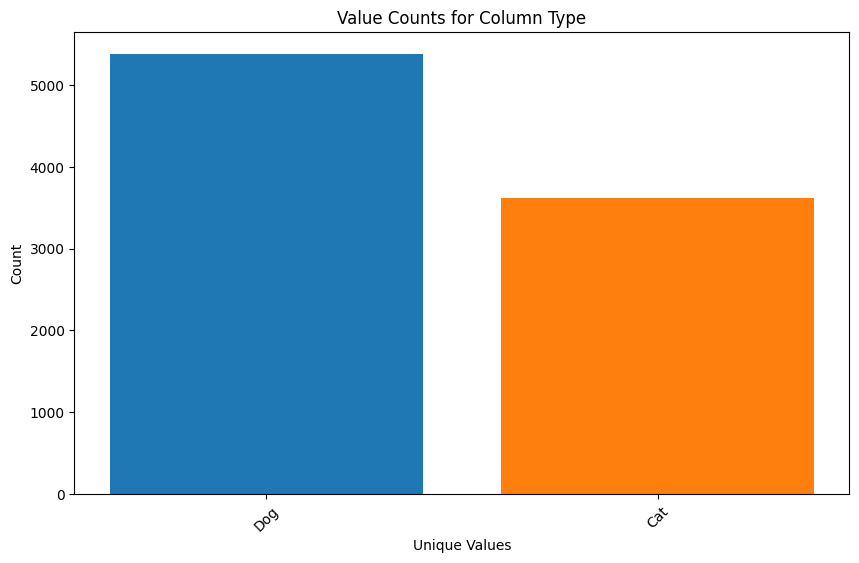

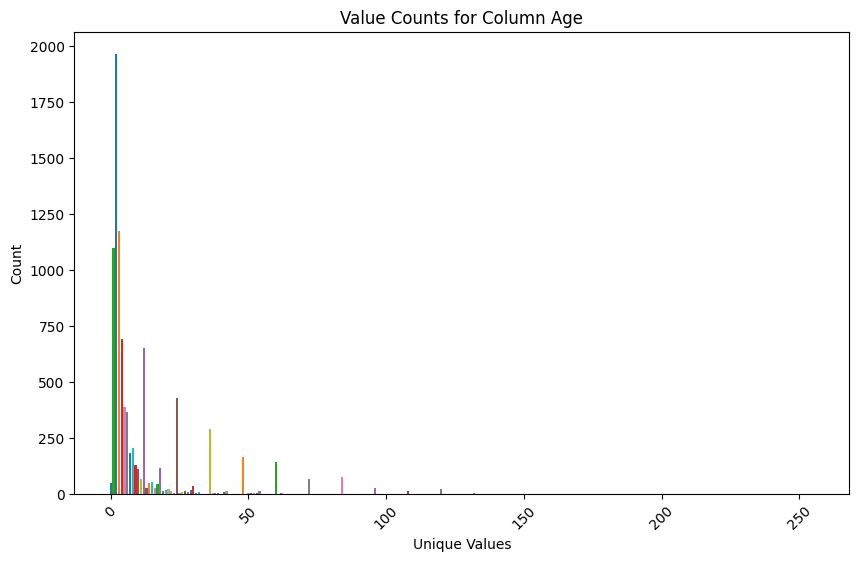

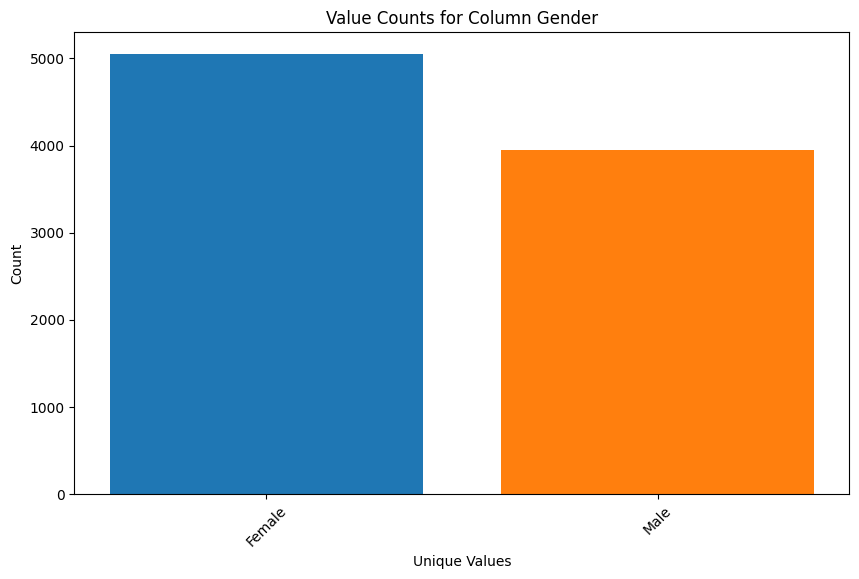

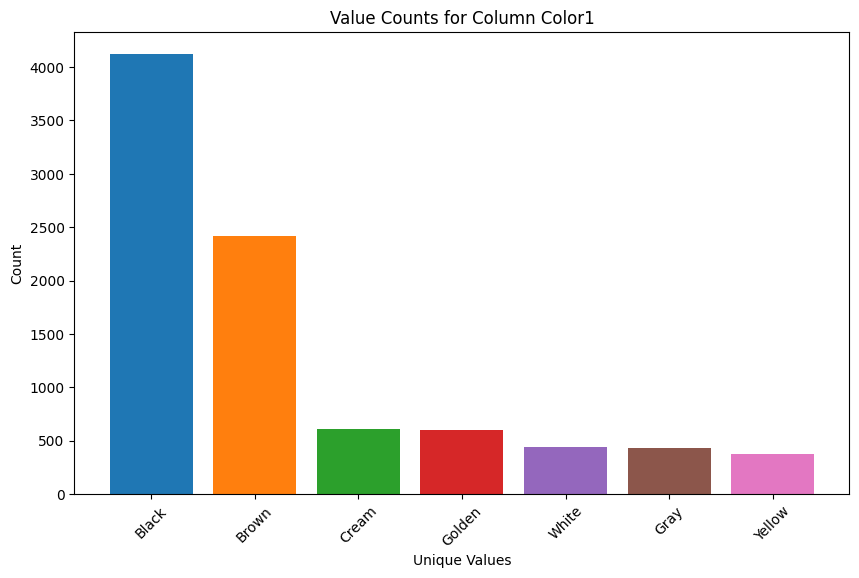

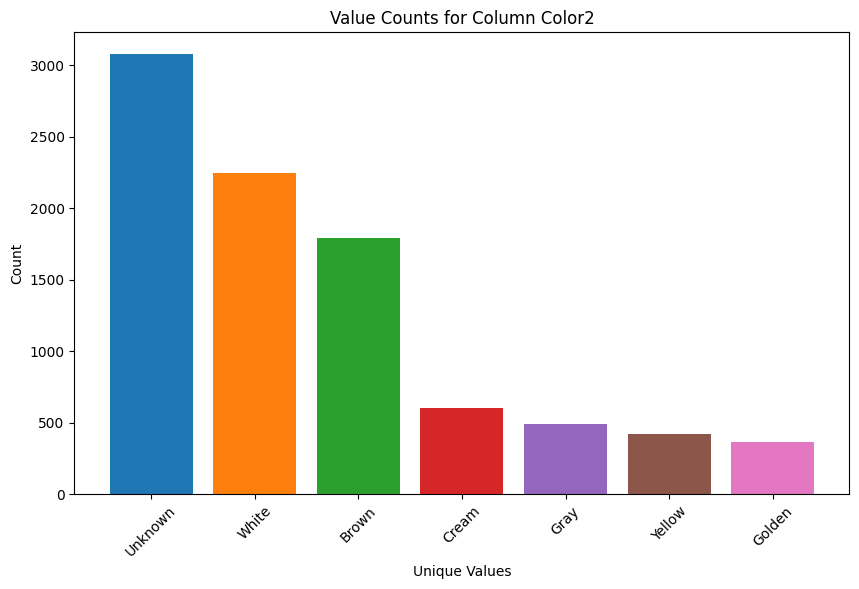

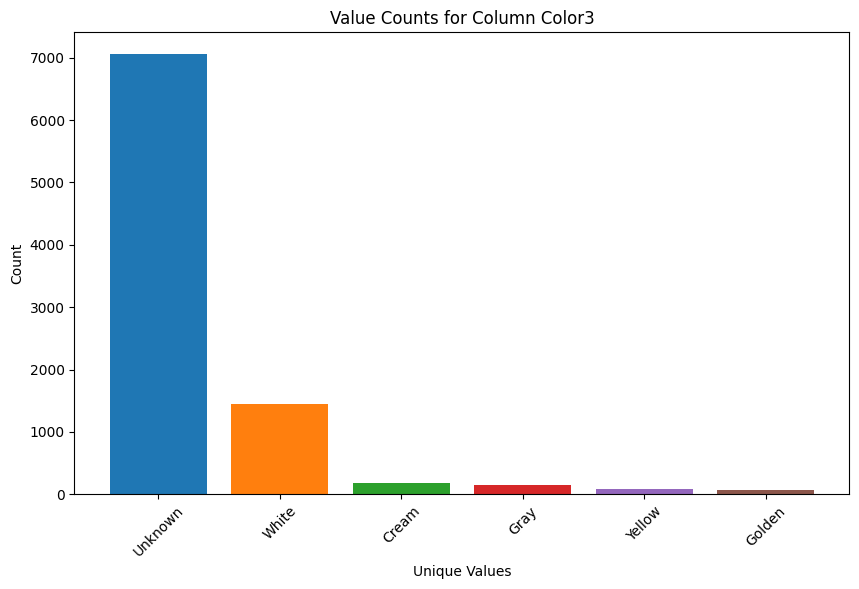

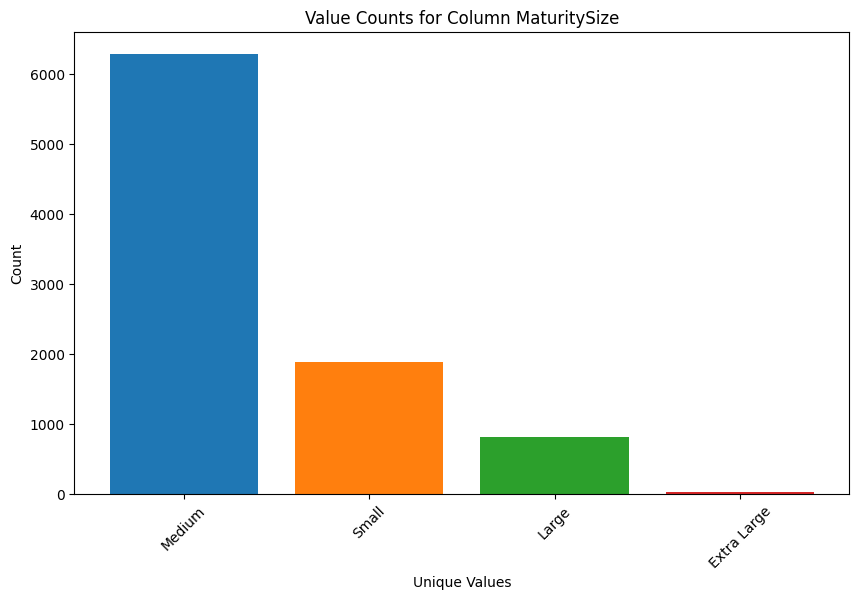

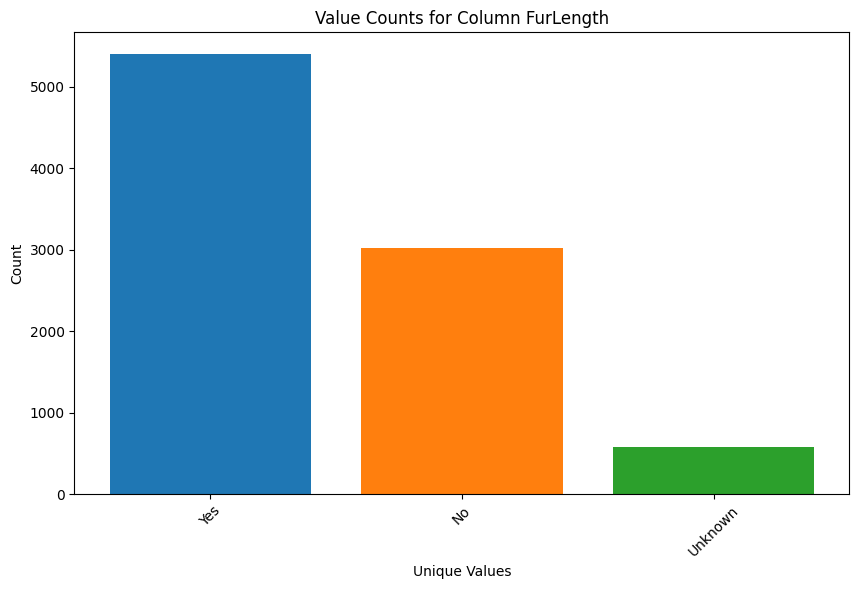

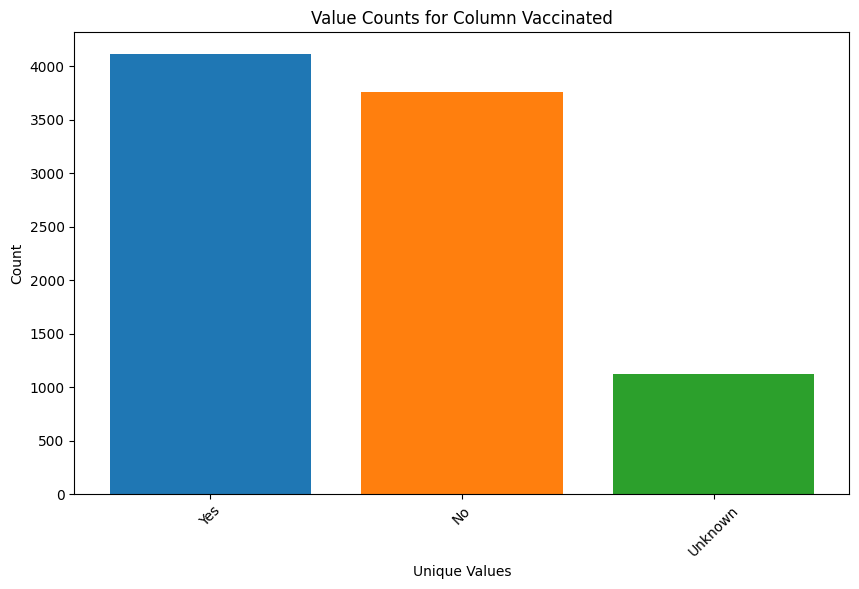

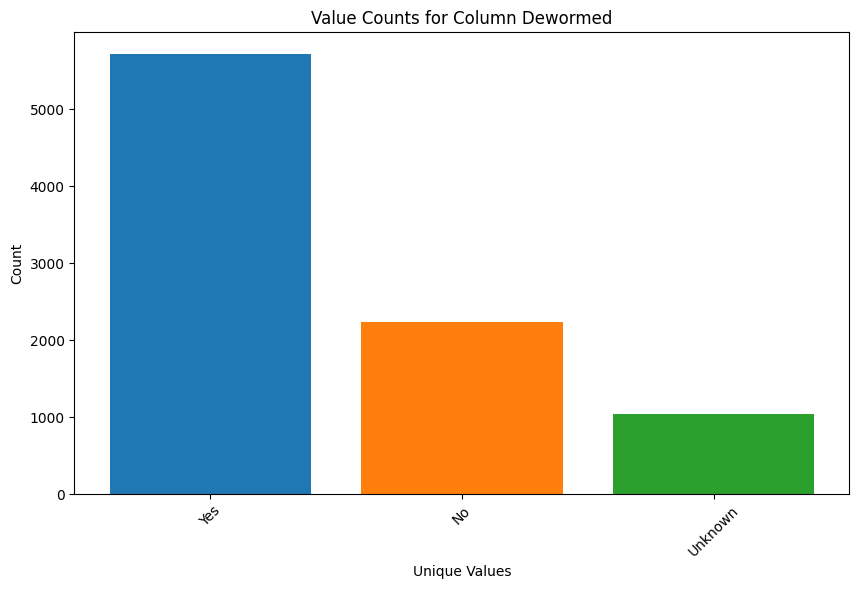

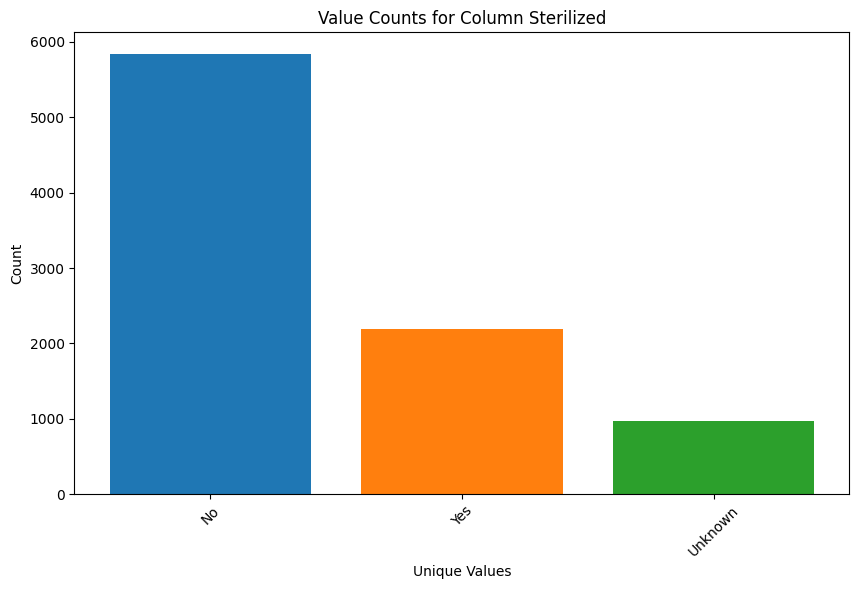

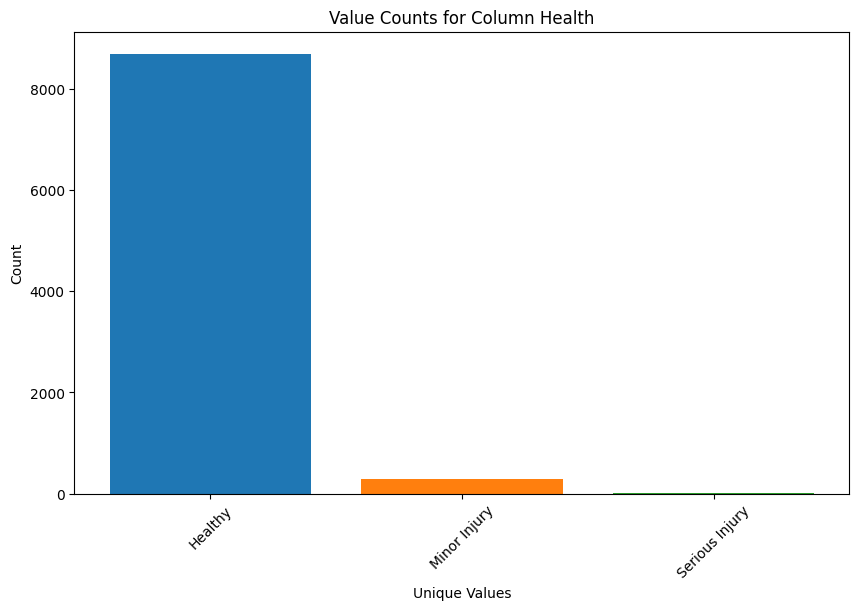

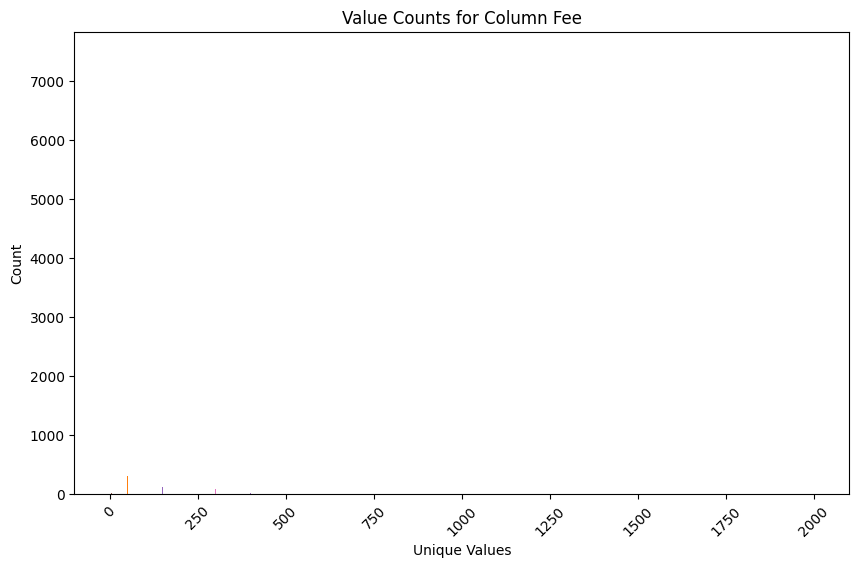

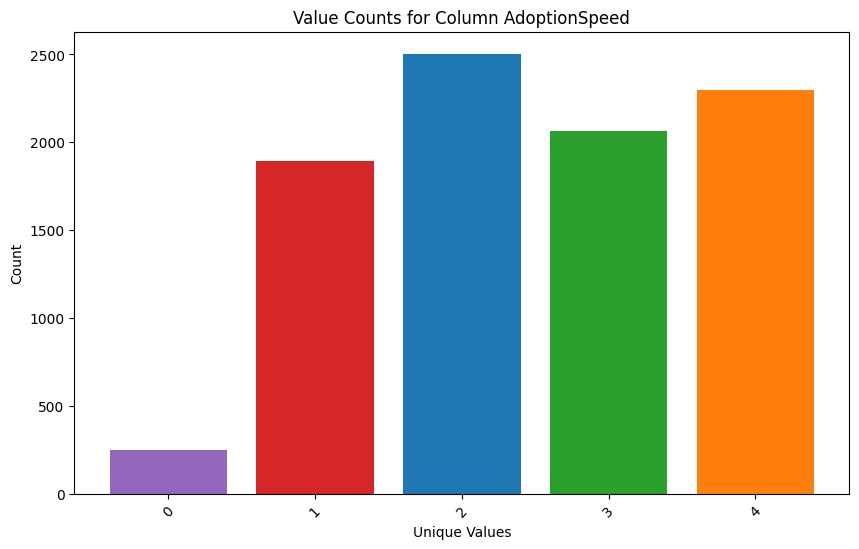

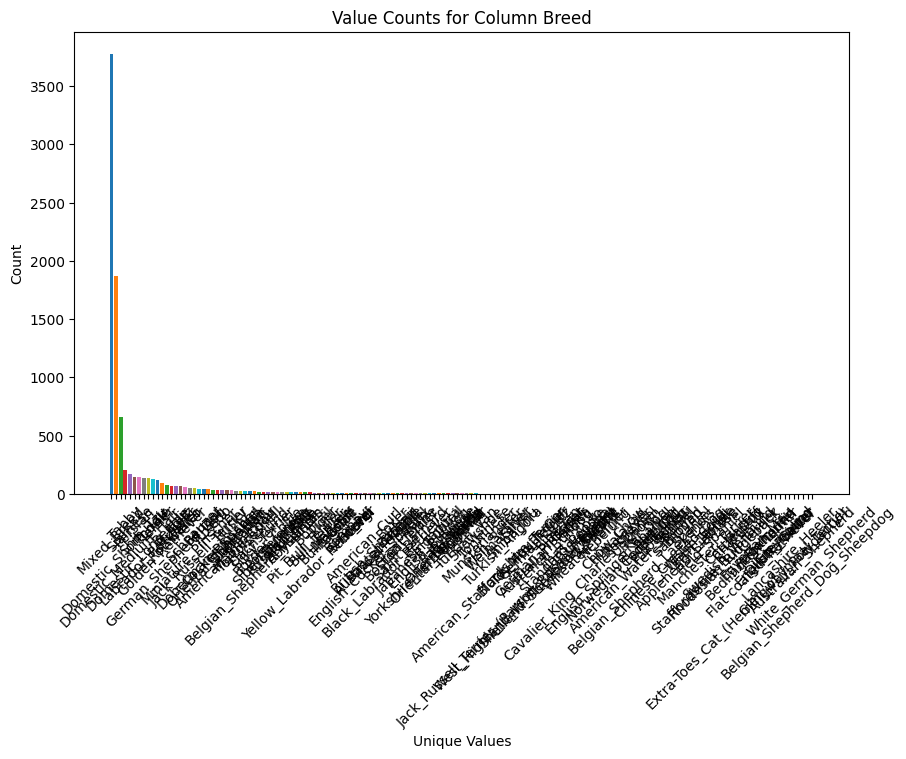

In [ ]:
import seaborn as sns

# Iterate over columns
for col_name in df_train.columns:
    if col_name not in ['Description', 'Images']:

      value_counts = df_train[col_name].value_counts()
      num_unique_values = len(value_counts)
      colors = sns.color_palette('tab10', num_unique_values)

      plt.figure(figsize=(10, 6))
      plt.bar(x=value_counts.index, height=value_counts.values, color=colors)
      plt.title(f"Value Counts for Column {col_name}")
      plt.xlabel("Unique Values")
      plt.ylabel("Count")
      plt.xticks(rotation=45)
      plt.show()
      print()

We can observe that the column 'Color3' has too many unknown value

In [ ]:
df_train['Color3'].value_counts()

Unknown    7055
White      1451
Cream       186
Gray        146
Yellow       88
Golden       74
Name: Color3, dtype: int64

###Missing values

Due to the fact that the column Color 3 has so many unknow values we will proceed to remove it from the dataset.  This is part of ***feature selection*** because we decide to not use this column.

In [ ]:
df_train.drop('Color3', axis=1, inplace=True)

In [ ]:
df_test.drop('Color3', axis=1, inplace=True)

###Checking outliers

We firt select the numerical columns and then go over them

In [ ]:
numerical_cols = df_train.select_dtypes(include='number')

In [ ]:
numerical_cols.head()

,Age,Fee,AdoptionSpeed
0,84.0,0.0,4.0
1,1.0,50.0,3.0
2,1.0,0.0,1.0
3,3.0,0.0,4.0
4,8.0,0.0,3.0


Then we use boxplot to visualize the outliers in the numerical columns of the dataset

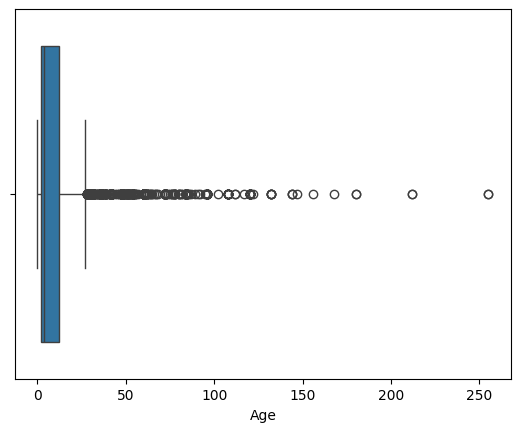

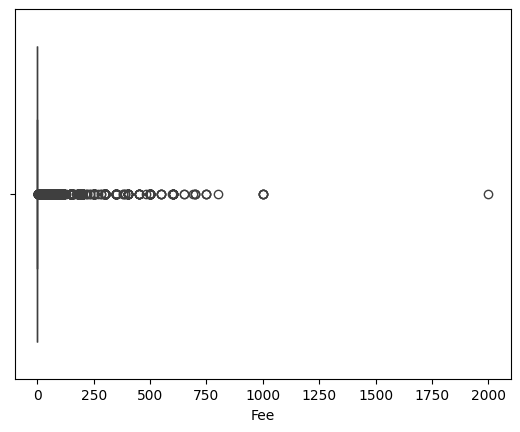

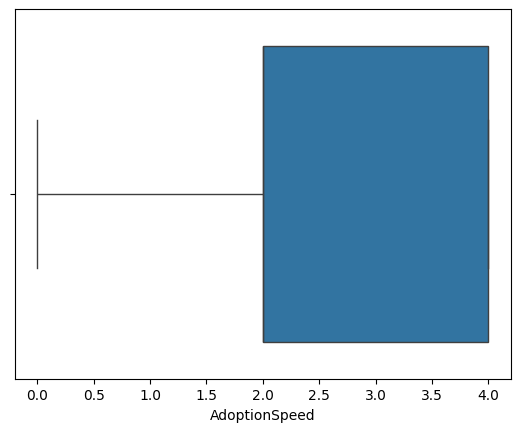

In [ ]:
for i, cols in enumerate(numerical_cols.columns):
  plt.figure(i)
  sns.boxplot(x=df_train[cols])

We also create a function to check and know the number of outliers of the dataset

In [ ]:
from scipy import stats

def check_number_of_outliers(dataframe):
  z = np.abs(dataframe.apply(stats.zscore))
  outliers= np.column_stack(np.where(z >3))
  return len(outliers)

In [ ]:
check_number_of_outliers(numerical_cols)

499

With the previous information it can be observed the number of outliers are not many but from the previous graphs we can see that the age outliers must be mistakes because cats and dogs only live until 18 years, with 30 being a world record, therefore we proceed to remove the outliers of this specific column by turning them into nan values

In [ ]:
age= df_train['Age']
z = np.abs(stats.zscore(age))
outliers = np.where(z >3)
outliers_indices = outliers[0]
#Set outliers to NaN
df_train.loc[outliers_indices, 'Age'] = np.nan

Same in the test

In [ ]:
age= df_test['Age']
z = np.abs(stats.zscore(age))
outliers = np.where(z >3)
outliers_indices = outliers[0]
#Set outliers to NaN
df_test.loc[outliers_indices, 'Age'] = np.nan

In [ ]:
df_train.shape

(9000, 16)

###Checking correlation

We also check if there exists a correlation between the numerical columns

In [ ]:
df2= numerical_cols.corr()

In [ ]:
df2

,Age,Fee,AdoptionSpeed
Age,1.000000,0.079858,0.111585
Fee,0.079858,1.000000,-0.013735
AdoptionSpeed,0.111585,-0.013735,1.000000


We can observe there is no correlation between them

##**Feature Engineering**

###Separating the categorical columns

Analyzing the columns we have, we can see that most of them are ready to be preprocessed directly on the pipeline. However, the description column and the image columns requiere an specific preprocessing.

####Text

For the descriptions we need NLP (Natural Language Preprocessing) to allow our model to understand the data, for this purpose we use the nltk library which contains several tools to deal with text.

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

We create a function that goes over a text and regularizes it: by making all its letters lower case, getting rid of punctuation and tokenizing words to then go over them and removing stop words taking into account the descriptions are in english, and then lemmatizing the words.

We do not get rid of repeated words because they will be useful for our vectorizer.

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)

    #Removing stopwords: stop words are reccurring words that don't carry meaning in them
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    #Lemmatizing the tokens
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

    preprocessed_text = ' '.join(tokens_lemmatized)

    return preprocessed_text

We check the function on a description to see what it's doing

In [ ]:
df_train['Description'].iloc[0]

'He is either lost or abandoned. Please contact us if you know his owner...'

In [ ]:
preprocessed_text = preprocess_text(df_train['Description'].iloc[0])
preprocessed_text

'either lost abandoned please contact u know owner'

After checking we apply this function to all the texts contained in our 'Description' column, and then we make this a list

In [ ]:
preprocessed_description_texts = df_train['Description'].apply(preprocess_text)

In [ ]:
preprocessed_description_texts_x_TEST = df_test['Description'].apply(preprocess_text)

Now we'll use TfidVectorizer to vectorize the text. We select his vectorizer because we will nto be dealing with neural networks.

In [ ]:
df_train['Description'] = preprocessed_description_texts

In [ ]:
df_test['Description'] = preprocessed_description_texts_x_TEST

In [ ]:
df_train.head()

,Type,Age,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,AdoptionSpeed,Images,Breed
0,Dog,NaN,Male,Brown,Cream,Small,No,Unknown,Yes,No,Healthy,0.0,either lost abandoned please contact u know owner,4.0,3b178aa59-5.jpg,Terrier
1,Dog,1.0,Female,Black,Unknown,Medium,Yes,No,Yes,No,Healthy,50.0,hi name rose im friendly always happy see resc...,3.0,2fbf2cb7c-1.jpg,Mixed_Breed
2,Dog,1.0,Male,Brown,Unknown,Medium,Yes,No,No,No,Healthy,0.0,puppy age unknown husband went mountain biking...,1.0,97f683e04-1.jpg,Mixed_Breed
3,Dog,3.0,Male,Black,Unknown,Medium,Yes,Unknown,Yes,Unknown,Healthy,0.0,hi im randy week ago got beaten human caused b...,4.0,479500716-2.jpg,Mixed_Breed
4,Dog,8.0,Male,Brown,Unknown,Large,Yes,Yes,Yes,No,Healthy,0.0,abandoned puppy looking home hi johnny le 1 ye...,3.0,4a2270c3e-4.jpg,Mixed_Breed


####Images

Now we go onto accesing and preprocessing images.
First we create the functions access the images that are in zip folders on the drive, one to extract them and another one to search for them in the directory

In [ ]:
#We extract images from zip folders
def extract_images_from_zip(zip_folder_path, extracted_images_dir):
    with zipfile.ZipFile(zip_folder_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_images_dir)

#We find the image files in the nested directories
def find_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    return image_files

We proceed to create a new directory with all of the extracted files, we go throught the zip folders in our drive_adress directory and extract the images from there using our previous functions.

In [ ]:
#We create a directory where we'll save the extracted images
extracted_images_dir = 'extracted_images'
os.makedirs(extracted_images_dir, exist_ok=True)

#Extract images from each zip folder
for folder_name in os.listdir(drive_address):
    folder_path = os.path.join(drive_address, folder_name)

    #Check if the item in the directory is a zip folder
    if os.path.isfile(folder_path) and folder_name.endswith('.zip'):
        #Extract images from the zip folder
        extract_images_from_zip(folder_path, extracted_images_dir)

We load the vgg16 model

In [ ]:
#Loading the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Now create a model that takes vgg_model inputs as input but outputs the pool_output from the last layer, this to obtain just the necessary columns during the extraction of image features

In [ ]:
vgg_output=vgg_model.get_layer('block5_pool').output
pool_output = tf.keras.layers.GlobalAveragePooling2D()(vgg_output)
img_extractor_model = Model(inputs=vgg_model.input, outputs=pool_output)

img_extractor_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

We iterate through the column of images in our df_train dataframe and check if the information of the rows in this column matches the file name of the images extracted, if so we apply the preprocessimage function and append it to a list of preprocessed_images.

In [ ]:
#Search for the images' file names given in the training dataframe in the extracted images directory and preprocess them
preprocessed_images = []
features = []

for index, row in df_train.iterrows():
    image_filename = row['Images']
    image_path_found = False

    for root, dirs, files in os.walk(extracted_images_dir):
        if image_filename in files:
            image_path = os.path.join(root, image_filename)
            #We preprocess the image
            #preprocessed_img = preprocess_image(image_path)
            preprocessed_img = image.load_img(image_path, target_size=(224, 224))
            preprocessed_img = image.img_to_array(preprocessed_img) / 255.
            #We use the image extractor model in our preprocessed images and append it to a features list
            feature = img_extractor_model.predict(np.expand_dims(preprocessed_img, axis=0))
            features.append(feature)
            image_path_found = True
            break

    if image_path_found:
        preprocessed_images.append(preprocessed_img)
        #display(Image(filename=image_path))
print('finished')


Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 18ms/step
finished


In [ ]:
len(features)

9000

Visualizing the preprocessed_images

IndexError: index 10 is out of bounds for axis 0 with size 10

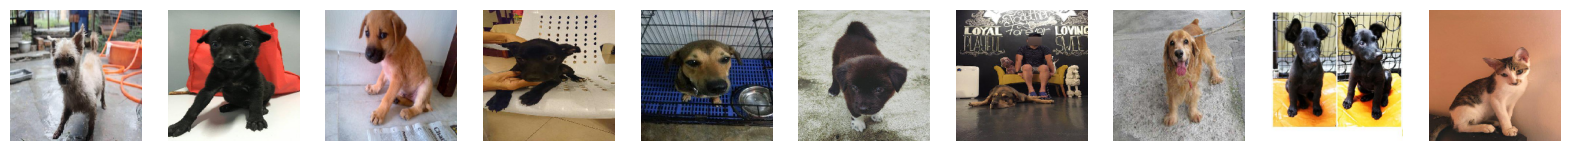

In [ ]:
fig, axes = plt.subplots(1, len(preprocessed_images[:10]), figsize=(20, 5))  # Adjust figsize as needed

for i, img_array in enumerate(preprocessed_images):
    axes[i].imshow(img_array)  # Remove the batch dimension for display
    axes[i].axis('off')

plt.show()

Then we convert the list of features of images into a numpy array and check its shape

In [ ]:
all_features = np.array(features)

In [ ]:
all_features.shape

(9000, 1, 512)

The features should have a shape of two, so we reshape it

In [ ]:
reshaped_features = all_features.reshape(all_features.shape[0], -1)

In [ ]:
reshaped_features.shape

(9000, 512)

In [ ]:
new_images = reshaped_features.tolist()
df_train['Images'] = new_images

In [ ]:
df_train.head()

,Type,Age,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,Images,Breed
0,Dog,NaN,Male,Brown,Cream,Small,No,Unknown,Yes,No,Healthy,0.0,either lost abandoned please contact u know owner,"[0.6056007742881775, 0.052681971341371536, 0.3...",Terrier
1,Dog,1.0,Female,Black,Unknown,Medium,Yes,No,Yes,No,Healthy,50.0,hi name rose im friendly always happy see resc...,"[0.2978900969028473, 0.0, 0.5624253749847412, ...",Mixed_Breed
2,Dog,1.0,Male,Brown,Unknown,Medium,Yes,No,No,No,Healthy,0.0,puppy age unknown husband went mountain biking...,"[0.49675989151000977, 0.0, 0.6083520650863647,...",Mixed_Breed
3,Dog,3.0,Male,Black,Unknown,Medium,Yes,Unknown,Yes,Unknown,Healthy,0.0,hi im randy week ago got beaten human caused b...,"[0.4578036963939667, 0.0, 0.3761186897754669, ...",Mixed_Breed
4,Dog,8.0,Male,Brown,Unknown,Large,Yes,Yes,Yes,No,Healthy,0.0,abandoned puppy looking home hi johnny le 1 ye...,"[0.379427045583725, 0.0, 0.2935502529144287, 0...",Mixed_Breed


We do the same with the test dataframe

In [ ]:
featuresTEST = []

for index, row in df_test.iterrows():
    image_filename = row['Images']
    image_path_found = False

    for root, dirs, files in os.walk(extracted_images_dir):
        if image_filename in files:
            image_path = os.path.join(root, image_filename)
            #We preprocess the image
            #preprocessed_img = preprocess_image(image_path)
            preprocessed_img = image.load_img(image_path, target_size=(224, 224))
            preprocessed_img = image.img_to_array(preprocessed_img) / 255.
            #We use the image extractor model in our preprocessed images and append it to a features list
            featureT = img_extractor_model.predict(np.expand_dims(preprocessed_img, axis=0))
            featuresTEST.append(featureT)
            break
print('finished')

1/1 [==============================] - 0s 20ms/step
finished


In [ ]:
all_featuresTEST = np.array(featuresTEST)

In [ ]:
all_featuresTEST.shape

(500, 1, 512)

In [ ]:
reshaped_TEST_features = all_featuresTEST.reshape(all_featuresTEST.shape[0], -1)
reshaped_TEST_features.shape

(500, 512)

The df_train 'Images' column is changed to new_images which contains the features of the images in the same order

In [ ]:
new_imagesTEST= reshaped_TEST_features.tolist()
df_test['Images'] = new_imagesTEST

In [ ]:
df_test.head()

,Type,Age,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,Images,Breed
0,Cat,1.0,Male,Black,White,Small,Yes,No,No,No,Healthy,0.0,kitten adoption pls call enquiry office hour t...,"[0.7517366409301758, 0.0, 0.4880293309688568, ...",Domestic_Short_Hair
1,Dog,8.0,Male,Black,Brown,Medium,Yes,No,No,No,Healthy,0.0,stray puppy came house obedient barkwhine when...,"[0.9180425405502319, 0.00026887046988122165, 1...",Mixed_Breed
2,Dog,2.0,Female,Brown,Cream,Medium,Unknown,Yes,Yes,No,Healthy,0.0,kind person rescued abandoned building interes...,"[0.25649067759513855, 0.0, 0.4048364460468292,...",Mixed_Breed
3,Dog,3.0,Female,Black,Brown,Medium,Yes,Yes,Yes,No,Healthy,0.0,sweety name say sweet fun cute little gal dump...,"[0.4193030297756195, 0.0, 0.4228282868862152, ...",Mixed_Breed
4,Cat,3.0,Female,Brown,Cream,Medium,Yes,No,No,No,Healthy,10.0,3 month old kitten adoption female pottytraine...,"[0.6366557478904724, 0.0, 0.16639479994773865,...",Domestic_Short_Hair


##**Feature selection**

We've previously done some feature selection by removing the Color3 column, but now we will define our X_train and y_train, and also we'll preprocess the data of the X_train columns according to their type (numerical, categorical..)

we take out the y variable of the train dataset

In [ ]:
df_train.shape, df_test.shape

((9000, 15), (500, 15))

In [ ]:
df_y= df_train.pop('AdoptionSpeed')
df_y.head()

0    4.0
1    3.0
2    1.0
3    4.0
4    3.0
Name: AdoptionSpeed, dtype: float64

Then we define the X_train, y_train, X_test and y_test for the training data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df_train, df_y, test_size=0.18, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

PIPELINE

In [ ]:
numeric_features = [f for f, t in zip(X_train.columns, X_train.dtypes) if t!="object"]

numeric_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='most_frequent')),
   ('scaler', StandardScaler())
])

numeric_features

['Age', 'Fee']

In categorical_features we pass all the columns that are not numeric, with the exception of the Images and Description columns. This due to the fact that the Images have already been preprocessed and the Description data requires a different preprocessing.

In [ ]:
categorical_features = [f for f in X_train.columns if f not in numeric_features and f not in ['Description', 'Images']]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


Then numerical and categorical features and its respective transformers are passed into the preprocessor of the pipeline

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop')

Drop the columns not included in the preprocessor, but now we'll concatenate them to it. To do so we first fit_transform our X_train, and transform our X_val, X_test as well

In [ ]:
train_tabular= preprocessor.fit_transform(X_train)
val_tabular= preprocessor.transform(X_val)
test_tabular= preprocessor.transform(X_test)

We do the same with the testing data

In [ ]:
real_X_test = df_test

In [ ]:
real_X_test.shape

(500, 15)

In [ ]:
real_testing_tabular= preprocessor.transform(real_X_test)

We Preprocess the description column

In [ ]:
vectorizer = TfidfVectorizer(max_features=300)
traintextvec = vectorizer.fit_transform(X_train['Description']).toarray()
Valtextvec = vectorizer.transform(X_val['Description']).toarray()
testtextvec = vectorizer.transform(X_test['Description']).toarray()

In [ ]:
real_X_test_textvec = vectorizer.transform(real_X_test['Description']).toarray()

In [ ]:
real_X_test_textvec.shape

(500, 300)

We convert the image column of the X_train into a list and then to an array so we can concatenate it with the train_tabular data

In [ ]:
image_train= np.array(X_train['Images'].tolist())
image_test= np.array(X_test['Images'].tolist())
image_val= np.array(X_val['Images'].tolist())

In [ ]:
image_train.shape

(7380, 512)

In [ ]:
image_real_X_TESTing= np.array(real_X_test['Images'].tolist())

In [ ]:
image_real_X_TESTing.shape

(500, 512)

Finally the images and text vectors are concatenated to the tabular data

In [ ]:
X_Train_concatenated = np.concatenate((train_tabular, image_train, traintextvec), axis=1)
X_Val_concatenated = np.concatenate((val_tabular, image_val, Valtextvec), axis=1)
X_Test_concatenated = np.concatenate((test_tabular, image_test, testtextvec), axis=1)

In [ ]:
X_Train_concatenated.shape

(7380, 999)

In [ ]:
real_X_Test_concatenated = np.concatenate((real_testing_tabular, image_real_X_TESTing, real_X_test_textvec), axis=1)

In [ ]:
real_X_Test_concatenated.shape

(500, 999)

#**Model Selection**  and results

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.ensemble import GradientBoostingClassifier

The scoring that will be used in the pipeline is created

In [ ]:
quadratic_kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

We select the models that might be good for this classification problem

In [ ]:
classifiers = {
    'LogisticRegression': (LogisticRegression(max_iter=10000), {'C': [0.001, 0.01, 0.1, 1]}),
    'DecisionTree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20], 'max_leaf_nodes': [None, 5, 10]}),
    'SVM': (SVC(), {'C': [0.01, 1], 'kernel': ['rbf']}),
    'RandomForest': (RandomForestClassifier(), {'n_estimators': [100, 200],
                                                 'max_depth': [None, 10, 20],
                                                 'min_samples_split': [2, 5, 10]}),
    'SGDClassifier': (SGDClassifier(), {'alpha': [0.001, 0.01], 'learning_rate': ['constant', 'optimal', 'adaptive'], 'eta0': [0.01, 0.1]}),
    'GradientBoosting': (GradientBoostingClassifier(), {'learning_rate': [ 0.1, 0.5], 'n_estimators': [100]})
}

We use cross validation grid search with all the models to see which models give the best results and with which parameters

In [ ]:
for model_name, (model, param_grid) in classifiers.items():

    grid_search = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=5,
        verbose=0,
        scoring= quadratic_kappa_scorer
    )

    grid_search.fit(X_Train_concatenated, y_train)

    acc_validation = grid_search.score(X_Val_concatenated, y_val)
    # Assign the best score from testing on the test set

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name} (training set): {grid_search.best_score_}")
    print(f"Best score for {model_name} (validation set): {acc_validation}")
    print('-'*36)

Best parameters for LogisticRegression: {'C': 0.1}
Best score for LogisticRegression (training set): 0.3141511101007448
Best score for LogisticRegression (validation set): 0.3371806739128361
------------------------------------
Best parameters for DecisionTree: {'max_depth': None, 'max_leaf_nodes': 10}
Best score for DecisionTree (training set): 0.2766241758506859
Best score for DecisionTree (validation set): 0.2998508605747914
------------------------------------
Best parameters for SVM: {'C': 1, 'kernel': 'rbf'}
Best score for SVM (training set): 0.2694557480452178
Best score for SVM (validation set): 0.2895239811317112
------------------------------------
Best parameters for RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best score for RandomForest (training set): 0.27390881913612597
Best score for RandomForest (validation set): 0.30900634293628737
------------------------------------
Best parameters for SGDClassifier: {'alpha': 0.01, 'eta0': 0.1, 'lear

KeyboardInterrupt: 

We observe from the cross validation grid search that decision tree and svm are giving the worse scores, and logistic regression and Gradient boosting are giving the best scores.

Due to this I retake the logistic regression with its default settings to see its results, same with Gradient boosting

---



In [ ]:
lr= LogisticRegression(max_iter=10_000).fit(X_Train_concatenated, y_train)

VALquadratic_kappa_score = quadratic_kappa_scorer(lr, X_Val_concatenated, y_val)
quadratic_kappa_score = quadratic_kappa_scorer(lr, X_Test_concatenated, y_test)
print("VAL Q Kappa score:", VALquadratic_kappa_score)
print("Quadratic Kappa score:", quadratic_kappa_score)

VAL Q Kappa score: 0.3413478862821705
Quadratic Kappa score: 0.31528200964650976


We observe that logistic regression with its already predefined parameters gives us a better score than in the cross-validation search

In [ ]:
#We first define verbose and early stopping parameters
verbose = 1
early_stopping = True

if verbose:
    print("Verbose mode enabled.")
    GradientBoostingClassifier().verbose = verbose

if early_stopping:
    print("Early stopping enabled.")
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    GradientBoostingClassifier().callbacks = [early_stopping_callback]
else:
    print("Early stopping disabled.")

best_model = GradientBoostingClassifier().fit(X_Train_concatenated, y_train)

quadratic_kappa_score_test = quadratic_kappa_scorer(best_model, X_Test_concatenated, y_test)
quadratic_kappa_score_val = quadratic_kappa_scorer(best_model, X_Val_concatenated, y_val)

Verbose mode enabled.
Early stopping enabled.


In [ ]:
print("Quadratic Kappa score:_test", quadratic_kappa_score_test)
print("Quadratic Kappa score:_val", quadratic_kappa_score_val)


Quadratic Kappa score:_test 0.37992015310613503
Quadratic Kappa score:_val 0.3860283507535981


We can observe that the kappa scores with the GradientBoositingClassifier model are higher, it's the model that gave the best results, so we use it to predict with the real_X_Test_concatenated and save this in the realy_pred_ML variable

In [ ]:
real_y_pred_ML= best_model.predict(real_X_Test_concatenated)

In [ ]:
real_y_pred_ML = real_y_pred_ML.astype(int)

We save the predictions in a csv file

In [ ]:
df = pd.DataFrame({'y_pred_ML': real_y_pred_ML, axis=1)})

# Save the DataFrame to a CSV file
df.to_csv('predictionsML_DL.csv', index=False)